In [12]:
import pandas as pd
import altair as alt
import networkx as nx
import nx_altair as nxa
from pydracor import *

dracor = DraCor()

In [13]:
plays = dracor.play_id_to_play_title()
available_german_plays = filtered_grades = dict(filter(lambda play: 'ger0' in play[0], plays.items()))
#available_german_plays

In [14]:
# play = Play('ger000088')
play = Play('ger000597')
#play = Play('ger000311') # Maria Stuart
# play = Play('ger000201') # Faust zwei, 189 Characters ie stress test 
graphml = play.relations_graphml()
# networkX doesn't support mix of directed+undirected Graphs & nx_altair's arrows look broken
# workaround: make graph undirected
graphml = graphml.replace('directed="true"', 'directed="false"')

G = nx.parse_graphml(graphml)
G.nodes.data()
G.edges.data()

' graphml = play.relations_graphml()\n# networkX doesn\'t support mix of directed+undirected Graphs & nx_altair\'s arrows look broken\n# workaround: make graph undirected\ngraphml = graphml.replace(\'directed="true"\', \'directed="false"\')\n\nG = nx.parse_graphml(graphml)\nG.nodes.data()\nG.edges.data() '

In [15]:
# Load corpera Metadata and select the metadata for play
gerCorp = Corpus('ger')
gerMetadata = pd.DataFrame(gerCorp.metadata())

# load play metadata ie the single line in da pd frame
playid = play.summary().get('id')
playMetadata = gerMetadata[gerMetadata["id"] == playid].reset_index()


   num_of_speakers_male  num_of_speakers_female  num_of_speakers_unknown
0                    88                      73                       28


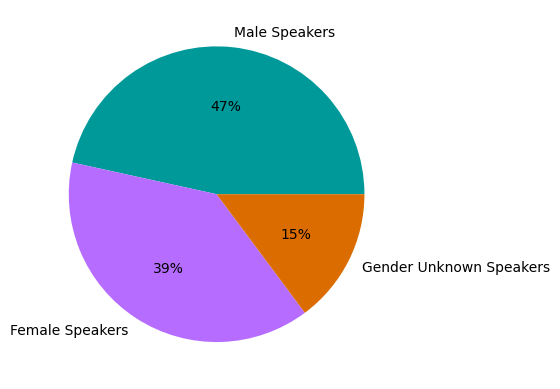

In [16]:
# 
import matplotlib.pyplot as plt 
import seaborn 
speakers=playMetadata[['num_of_speakers_male', 'num_of_speakers_female', 'num_of_speakers_unknown']]
print(speakers)
palette_color = seaborn.color_palette('bright')
labelSpeakerList = ['Male Speakers', 'Female Speakers', 'Gender Unknown Speakers'] 
# plotting data on chart male color #009999', Female color '#b66dff'unkown color'#db6d00' alternative palletwith different hue:#004949 #b66dff #ffdf4d  https://lospec.com/palette-list/colorblind-16
plt.pie(x=speakers.loc[0,:].values.tolist(),
        labels=labelSpeakerList, 
        colors=['#009999','#b66dff','#db6d00'], 
        autopct='%.0f%%') 
  
# displaying seaborn chart 
plt.show()
# alt chart 
#speakersAlt = speakers.T.rename(columns={'Index':'Speaker Gender', '0':'Number of Speakers'})
speakersAlt = pd.DataFrame({'genders':labelSpeakerList, 'Number of Speakers':speakers.loc[0,:].values.tolist()})

numeberSpeakerGenderPieAlt= alt.Chart(speakersAlt).mark_arc().encode(
    theta='Number of Speakers',
    color='genders'
)

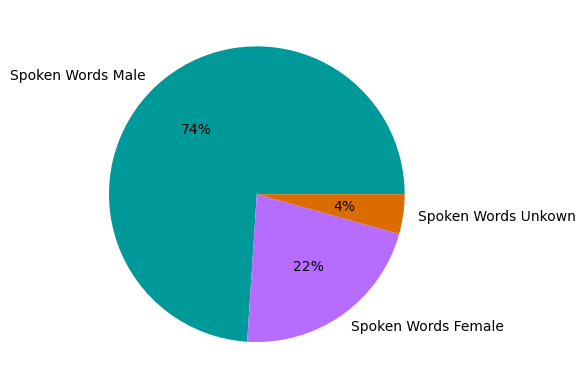

In [17]:
# Pie Chart Spoken words by gender
# 1. aggregate num. of spoken words by gender
coOGraphML = play.graphml()
coOGrapNX = nx.parse_graphml(coOGraphML,force_multigraph=True)
femaleWords = 0
maleWords = 0
unknownWords = 0
for nodeitterator in coOGrapNX.nodes: 
    node = coOGrapNX.nodes[nodeitterator]
    if node['Gender'] == 'FEMALE':
       femaleWords += node['Number of spoken words']
    elif node['Gender'] == 'MALE':
       maleWords += node['Number of spoken words']
    elif node['Gender'] == 'UNKNOWN':
       unknownWords += node['Number of spoken words']

spokenwordList = [maleWords,femaleWords,unknownWords] # odering the same way the gender of the speaker are in the metadata
# plot pie chart
plt.pie( x= spokenwordList, 
        labels= ['Spoken Words Male','Spoken Words Female','Spoken Words Unkown'], 
        colors=['#009999','#b66dff','#db6d00'], 
        autopct='%.0f%%') 
plt.show() 

# alt chart 
spokenwordListAlt = pd.DataFrame({'Genders':['Spoken Words Male','Spoken Words Female','Spoken Words Unkown'], 'Words':spokenwordList})

spokenWordsGenderPieCharAlt=alt.Chart(spokenwordListAlt).mark_arc().encode(
    theta='Words',
    color='Genders',
    
)

In [19]:
# define the graph layout
layout = nx.shell_layout(G)
#test set nodes shape --> does not work :/
#for ni in G.nodes:
#    G.nodes[ni]['shape'] = 'v'

# WTF die node_shape kann nur in nxa.draw_networkx_nodes() gesetzt werden aber nicht in draw_networkx
# draw graph with nx_altair
chart = nxa.draw_networkx(
    G,
    pos=layout,
    node_tooltip=['label', 'Gender'],
    node_color='lightgray',
    edge_color='Relation',
    width=2
)

# get the edge layer
edges = chart.layer[0]
# get the node layer
nodes = chart.layer[1]

# define relationship filter
relations = pd.DataFrame({'Relation': ['parent_of', 'lover_of', 'related_with', 'associated_with', 'siblings', 'spouses', 'friends']})
selection = alt.selection_point(fields=['Relation'], toggle="true")
color = alt.condition(selection, alt.Color('Relation:N', legend=None), alt.value('lightgray'))
relation_filter = alt.Chart(relations, title=alt.TitleParams('Filter Relationship', anchor='start')).mark_rect().encode(
    y=alt.Y('Relation', title=''), 
    color=color
).add_params(selection)

# add filter
edges = edges.encode(color='Relation').transform_filter(selection)

# filter nodes by gender
# options = ['MALE', 'FEMALE', 'UNKNOWN']
# labels = [option + ' ' for option in options]
# radio_buttons = alt.binding_radio(
#     options=options + [None],
#     labels=labels + ['ALL'],
#     name='Gender: '
# )
# selection = alt.selection_single(
#     fields=['Gender'],
#     bind=radio_buttons,
# )
# nodes = nodes.encode(
#     fill=alt.Color('Gender:N').scale(domain=options)
# ).add_params(
#     selection
# ).transform_filter(
#     selection
# )

# print the Chart layers #beene look at this | charts next to each other , + lay charts overeach
(relation_filter | (edges+nodes)| (spokenWordsGenderPieCharAlt & numeberSpeakerGenderPieAlt) ).configure_view(
    strokeWidth=0 # remove border
).configure_axis(
    domainOpacity=0 # remove axis
)

alt.HConcatChart(...)